# Notebook 04 — Modelo de Diagnóstico: CLAY vs UF

**Proyecto:** Thickener Water Recovery Sentinel (TWS)  
**Tarea:** Clasificación binaria condicionada — *dado que hay un evento, ¿es CLAY o UF?*  
**Restricción:** Solo `FEATURES_PROD` (datos reales de planta, sin variables latentes del simulador).

## Contexto operacional
El diagnóstico correcto importa porque las acciones correctivas son distintas:
- **CLAY**: aumentar floculante, dilución en feedwell, reducir carga si es posible.
- **UF (Underflow failure)**: aumentar caudal de purga, revisar bomba/válvula de underflow.

## Pipeline
1. Carga y exploración de eventos
2. Análisis de separabilidad en variables reales
3. Split estratificado temporal por clase
4. Baseline: regla simple por umbral
5. Modelo LightGBM
6. Evaluación + matriz de confusión
7. Feature importance + SHAP
8. Interpretación física de las firmas
9. Discusión: limitaciones en producción


In [1]:
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import lightgbm as lgb
import shap

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    roc_curve, classification_report,
    confusion_matrix, f1_score,
    precision_score, recall_score
)

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', context='talk')
rng = np.random.default_rng(42)

# ── Carga ────────────────────────────────────────────────────────────────────
feat = pd.read_parquet('../data/processed/thickener_features.parquet')
feat['timestamp'] = pd.to_datetime(feat['timestamp'])
feat = feat.sort_values('timestamp').reset_index(drop=True)
feat['day'] = (feat['timestamp'] - feat['timestamp'].min()).dt.days

with open('../data/processed/feature_catalogs.json') as f:
    catalogs = json.load(f)
FEATURES_PROD = catalogs['FEATURES_PROD']

# ── Filtro: solo eventos con diagnosis CLAY o UF ──────────────────────────
diag = feat[
    (feat['event_now'] == 1) &
    (feat['event_type'].isin(['CLAY', 'UF']))
].copy().reset_index(drop=True)

# Label: CLAY=1, UF=0
diag['label'] = (diag['event_type'] == 'CLAY').astype(int)
TARGET_DIAG = 'label'

print(f'Filas de diagnostico: {len(diag):,}')
print(f'  CLAY (label=1): {(diag.label==1).sum():,} ({(diag.label==1).mean():.1%})')
print(f'  UF   (label=0): {(diag.label==0).sum():,} ({(diag.label==0).mean():.1%})')
print(f'\nRango temporal:')
print(f'  CLAY: dia {diag[diag.label==1].day.min()} a {diag[diag.label==1].day.max()}')
print(f'  UF  : dia {diag[diag.label==0].day.min()} a {diag[diag.label==0].day.max()}')


c:\Users\Matias\TWS\Thickener-Water-Recovery-Sentinel-TWS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Filas de diagnostico: 1,209
  CLAY (label=1): 784 (64.8%)
  UF   (label=0): 425 (35.2%)

Rango temporal:
  CLAY: dia 14 a 40
  UF  : dia 14 a 52


## 1. Exploración: ¿qué variables reales separan CLAY de UF?

Analizamos las variables de planta disponibles durante los eventos para ver cuánta separación natural hay.


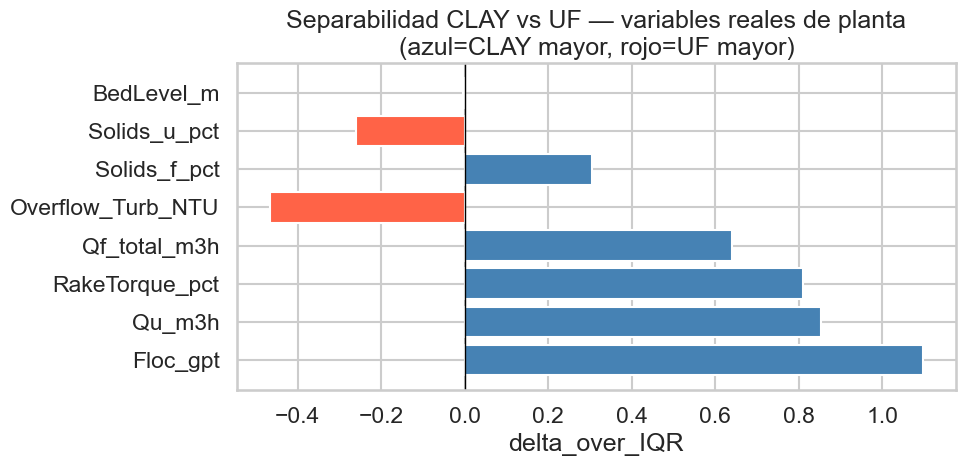

         variable  median_CLAY  median_UF  delta_over_IQR
         Floc_gpt    35.000000  23.995209        1.098821
           Qu_m3h   261.898020 193.598726        0.854266
   RakeTorque_pct   119.379666  64.196849        0.811484
     Qf_total_m3h   607.237964 527.382762        0.640550
Overflow_Turb_NTU   133.276850 155.620705       -0.467325
     Solids_f_pct    33.018107  31.723238        0.304005
     Solids_u_pct    66.072421  66.985519       -0.260711
       BedLevel_m     3.497465   3.500000       -0.003142


In [2]:
# Variables de planta con potencial diagnóstico
REAL_DIAG_VARS = [
    'BedLevel_m',
    'RakeTorque_pct',
    'Qu_m3h',
    'Floc_gpt',
    'Solids_u_pct',
    'Overflow_Turb_NTU',
    'Solids_f_pct',
    'Qf_total_m3h',
]

# delta_over_IQR entre CLAY y UF
clay = diag[diag['label'] == 1]
uf   = diag[diag['label'] == 0]

rows = []
for f in REAL_DIAG_VARS:
    m_clay = float(clay[f].median())
    m_uf   = float(uf[f].median())
    iqr    = float(diag[f].quantile(0.75) - diag[f].quantile(0.25)) + 1e-9
    rows.append({
        'variable':     f,
        'median_CLAY':  m_clay,
        'median_UF':    m_uf,
        'delta_over_IQR': (m_clay - m_uf) / iqr,
    })
sep = pd.DataFrame(rows).sort_values('delta_over_IQR', key=abs, ascending=False)

colors = ['steelblue' if v > 0 else 'tomato' for v in sep['delta_over_IQR']]
fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(sep['variable'], sep['delta_over_IQR'], color=colors)
ax.axvline(0, color='black', lw=1)
ax.set_title('Separabilidad CLAY vs UF — variables reales de planta\n(azul=CLAY mayor, rojo=UF mayor)')
ax.set_xlabel('delta_over_IQR')
plt.tight_layout()
plt.show()

print(sep.to_string(index=False))


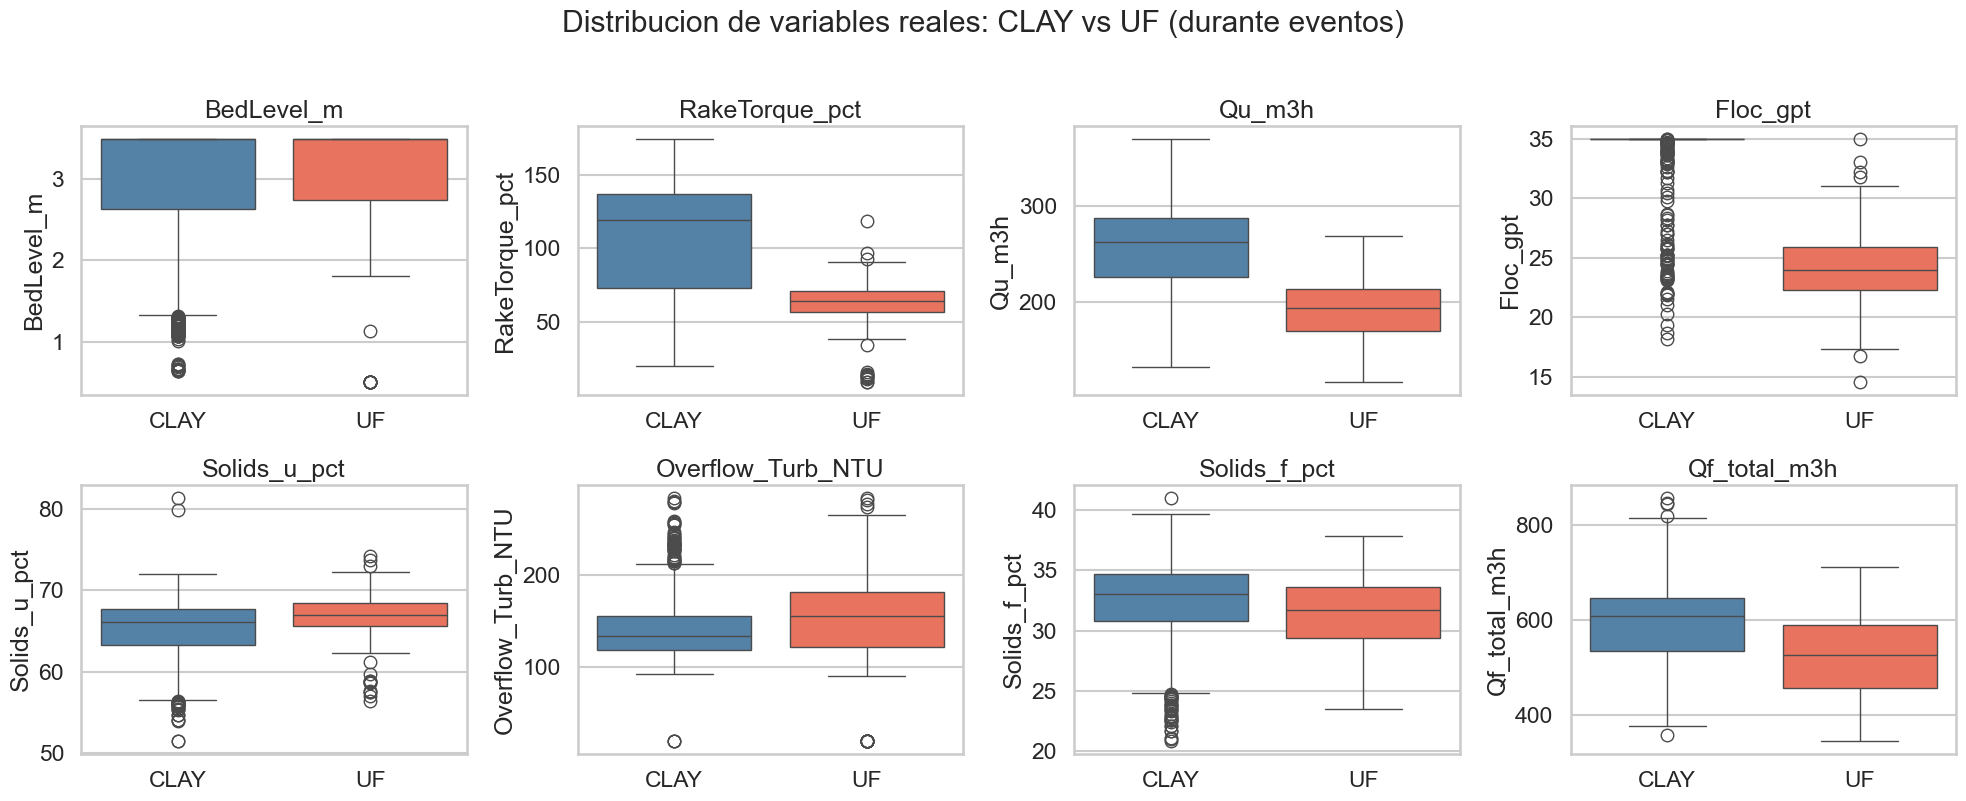

In [3]:
# Boxplots comparativos
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()

for ax, var in zip(axes, REAL_DIAG_VARS):
    sns.boxplot(diag, x='event_type', y=var, order=['CLAY','UF'], ax=ax,
                palette={'CLAY':'steelblue','UF':'tomato'})
    ax.set_title(var)
    ax.set_xlabel('')

plt.suptitle('Distribucion de variables reales: CLAY vs UF (durante eventos)', y=1.01)
plt.tight_layout()
plt.show()


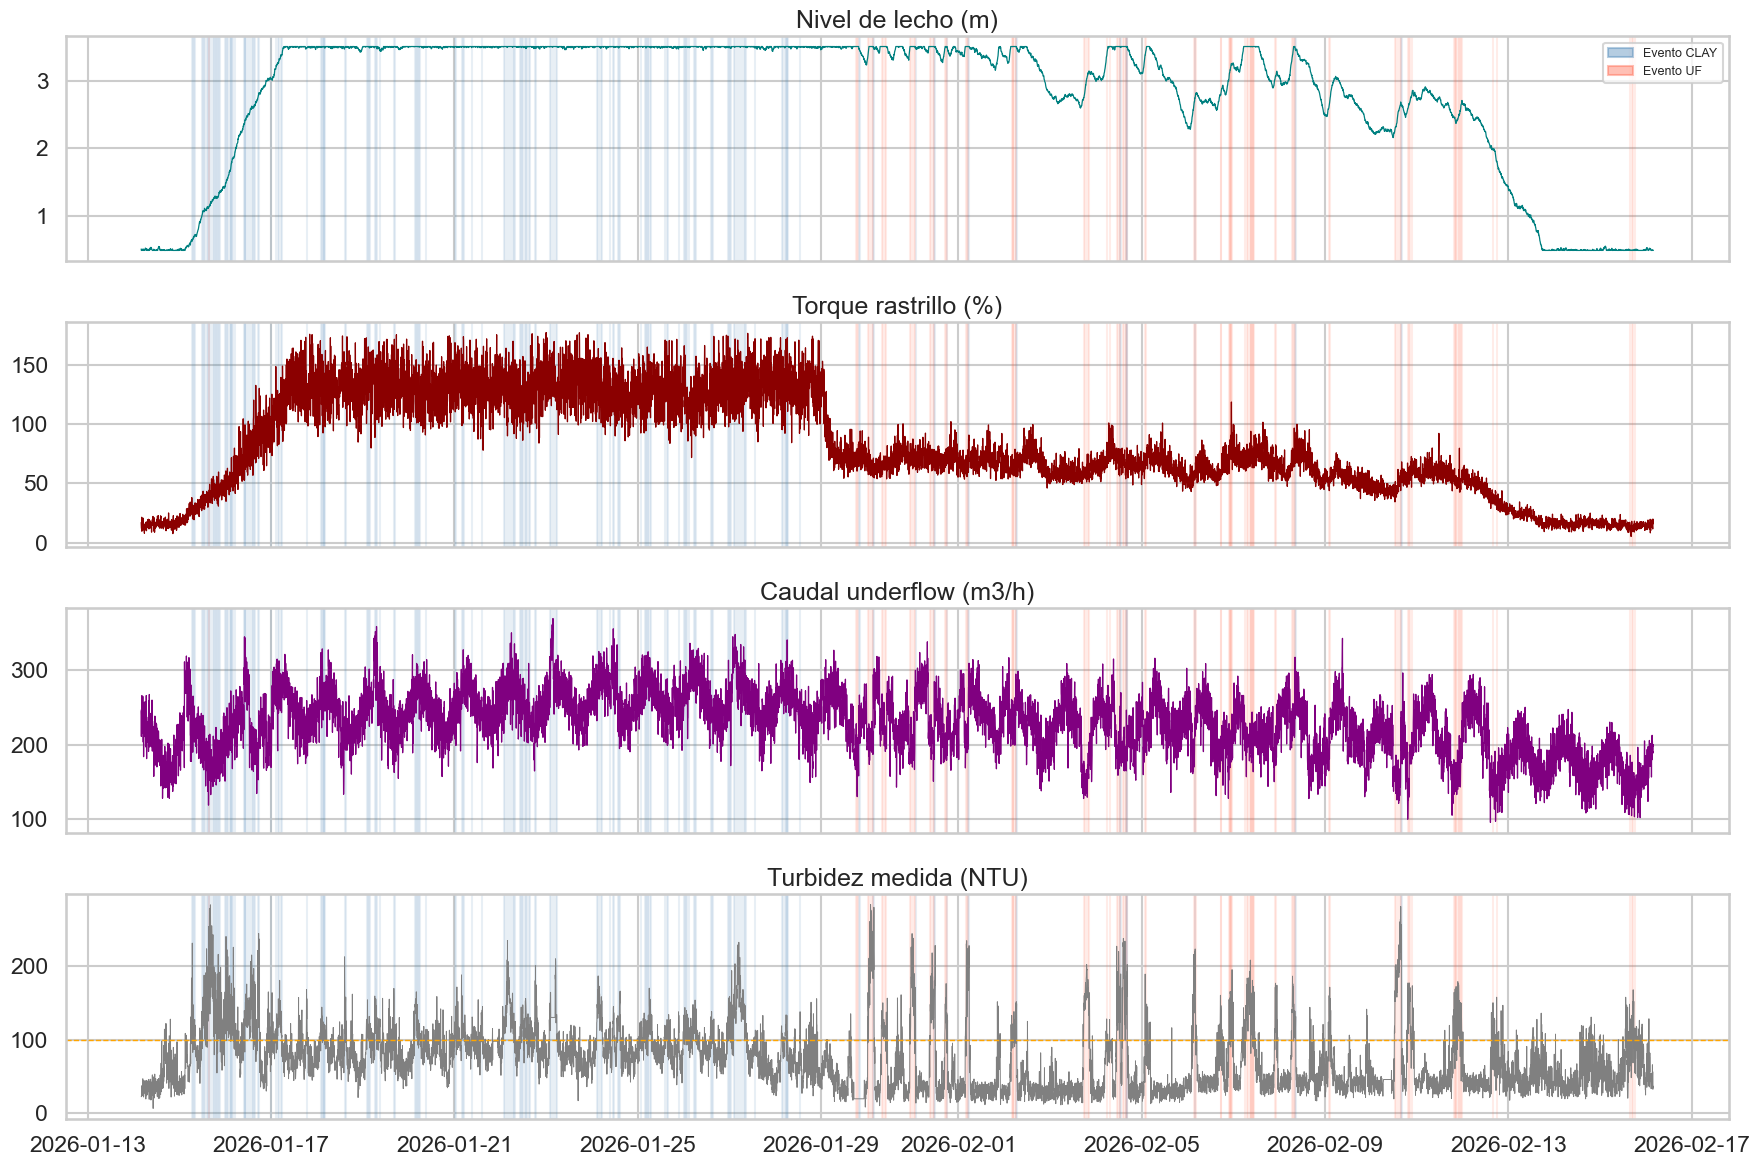

In [4]:
# Series temporales de las variables clave durante el periodo de campanas
# (incluye contexto no-evento para ver el patron completo)
window = feat[(feat['day'] >= 13) & (feat['day'] <= 45)].set_index('timestamp')

fig, axes = plt.subplots(4, 1, figsize=(18, 12), sharex=True)

ev_mask = window['event_type'].isin(['CLAY', 'UF'])

for ax in axes:
    ax.fill_between(window.index, 0, 1,
                    where=(window['event_type'] == 'CLAY'),
                    transform=ax.get_xaxis_transform(),
                    color='steelblue', alpha=0.12, step='pre', label='CLAY')
    ax.fill_between(window.index, 0, 1,
                    where=(window['event_type'] == 'UF'),
                    transform=ax.get_xaxis_transform(),
                    color='tomato', alpha=0.12, step='pre', label='UF')

axes[0].plot(window.index, window['BedLevel_m'],    color='teal',    lw=0.9)
axes[0].set_title('Nivel de lecho (m)')

axes[1].plot(window.index, window['RakeTorque_pct'], color='darkred', lw=0.9)
axes[1].set_title('Torque rastrillo (%)')

axes[2].plot(window.index, window['Qu_m3h'],         color='purple',  lw=0.9)
axes[2].set_title('Caudal underflow (m3/h)')

axes[3].plot(window.index, window['Overflow_Turb_NTU'], color='gray', lw=0.7, label='Medida')
axes[3].axhline(100, color='orange', ls='--', lw=1)
axes[3].set_title('Turbidez medida (NTU)')

handles = [
    mpatches.Patch(color='steelblue', alpha=0.4, label='Evento CLAY'),
    mpatches.Patch(color='tomato',    alpha=0.4, label='Evento UF'),
]
axes[0].legend(handles=handles, loc='upper right', fontsize=9)
plt.tight_layout()
plt.show()


## 2. Split estratificado temporal

**Problema de diseño:** CLAY ocurre principalmente en días 14–27, UF en días 28–52.  
Un split temporal simple separaría las clases completamente, haciendo trivial la tarea para el modelo  
(solo aprendería la posición en el tiempo, no la física del proceso).

**Solución:** Split estratificado dentro de cada clase, preservando el orden temporal:  
- Tomar el **70% más antiguo de CLAY** como train + **70% más antiguo de UF** como train  
- Test = **30% más reciente de cada clase**

Esto obliga al modelo a generalizar dentro de cada tipo de campaña, no a memorizar la posición temporal.


In [5]:
TRAIN_FRAC = 0.70

def temporal_split(df, frac=0.70):
    n_train = int(len(df) * frac)
    return df.iloc[:n_train], df.iloc[n_train:]

clay_df = diag[diag['label'] == 1].reset_index(drop=True)
uf_df   = diag[diag['label'] == 0].reset_index(drop=True)

clay_tr, clay_te = temporal_split(clay_df, TRAIN_FRAC)
uf_tr,   uf_te   = temporal_split(uf_df,   TRAIN_FRAC)

train_diag = pd.concat([clay_tr, uf_tr]).sort_values('timestamp').reset_index(drop=True)
test_diag  = pd.concat([clay_te, uf_te]).sort_values('timestamp').reset_index(drop=True)

X_train = train_diag[FEATURES_PROD]
y_train = train_diag[TARGET_DIAG]
X_test  = test_diag[FEATURES_PROD]
y_test  = test_diag[TARGET_DIAG]

print('Train:')
print(f'  Total: {len(train_diag):,} | CLAY: {(y_train==1).sum()} | UF: {(y_train==0).sum()}')
print(f'  Periodo CLAY train: dia {clay_tr.day.min()} a {clay_tr.day.max()}')
print(f'  Periodo UF train  : dia {uf_tr.day.min()} a {uf_tr.day.max()}')
print('Test:')
print(f'  Total: {len(test_diag):,}  | CLAY: {(y_test==1).sum()} | UF: {(y_test==0).sum()}')
print(f'  Periodo CLAY test : dia {clay_te.day.min()} a {clay_te.day.max()}')
print(f'  Periodo UF test   : dia {uf_te.day.min()} a {uf_te.day.max()}')


Train:
  Total: 845 | CLAY: 548 | UF: 297
  Periodo CLAY train: dia 14 a 24
  Periodo UF train  : dia 14 a 37
Test:
  Total: 364  | CLAY: 236 | UF: 128
  Periodo CLAY test : dia 24 a 40
  Periodo UF test   : dia 37 a 52


## 3. Baseline: regla simple

Si `BedLevel_m > umbral` → CLAY, sino → UF.


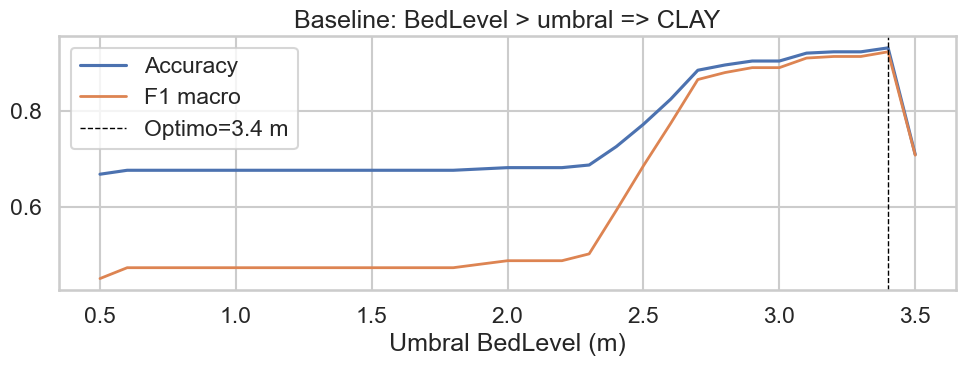

Mejor baseline: BedLevel > 3.4 m
  Accuracy=0.931 | F1-macro=0.923

Report baseline:
              precision    recall  f1-score   support

          UF       0.94      0.86      0.90       128
        CLAY       0.93      0.97      0.95       236

    accuracy                           0.93       364
   macro avg       0.93      0.91      0.92       364
weighted avg       0.93      0.93      0.93       364



In [6]:
thresholds = np.arange(0.5, 3.6, 0.1)
rows = []
for thr in thresholds:
    y_pred_bl = (test_diag['BedLevel_m'] > thr).astype(int)
    rows.append({
        'threshold': thr,
        'accuracy': (y_pred_bl == y_test).mean(),
        'f1_clay':  f1_score(y_test, y_pred_bl, pos_label=1, zero_division=0),
        'f1_uf':    f1_score(y_test, y_pred_bl, pos_label=0, zero_division=0),
    })
bl = pd.DataFrame(rows)
bl['f1_macro'] = (bl['f1_clay'] + bl['f1_uf']) / 2

best_bl = bl.loc[bl['f1_macro'].idxmax()]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(bl['threshold'], bl['accuracy'],  label='Accuracy')
ax.plot(bl['threshold'], bl['f1_macro'],  label='F1 macro', lw=2)
ax.axvline(best_bl.threshold, color='black', ls='--', lw=1,
           label=f'Optimo={best_bl.threshold:.1f} m')
ax.set_xlabel('Umbral BedLevel (m)')
ax.set_title('Baseline: BedLevel > umbral => CLAY')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Mejor baseline: BedLevel > {best_bl.threshold:.1f} m')
print(f'  Accuracy={best_bl.accuracy:.3f} | F1-macro={best_bl.f1_macro:.3f}')

y_bl_best = (test_diag['BedLevel_m'] > best_bl.threshold).astype(int)
print('\nReport baseline:')
print(classification_report(y_test, y_bl_best, labels=[0,1],
                             target_names=['UF','CLAY']))


## 4. Modelo LightGBM


In [7]:
from sklearn.model_selection import train_test_split

# Dataset pequeno (845 eventos) vs 159 features -> riesgo de overfitting severo.
# Soluciones:
#   1. Usar FEATURES_TOP30_PROD (30 features con mayor MI, solo produccion)
#   2. n_estimators=100 fijo, sin early stopping
#   3. class_weight='balanced'
FEAT_DIAG = catalogs['FEATURES_TOP30_PROD']
X_train_d = train_diag[FEAT_DIAG]
X_test_d  = test_diag[FEAT_DIAG]

model_diag = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=15,
    max_depth=4,
    min_child_samples=15,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=-1,
)

model_diag.fit(X_train_d, y_train)

print(f'Features usadas: {len(FEAT_DIAG)} (FEATURES_TOP30_PROD)')
print(f'Estimators: {model_diag.n_estimators}')
print(f'CLAY train: {(y_train==1).sum()} | UF train: {(y_train==0).sum()}')


Features usadas: 30 (FEATURES_TOP30_PROD)
Estimators: 100
CLAY train: 548 | UF train: 297


## 5. Evaluación en Test

ROC-AUC (CLAY vs UF): 0.8363

              precision    recall  f1-score   support

          UF       0.71      1.00      0.83       128
        CLAY       1.00      0.78      0.87       236

    accuracy                           0.85       364
   macro avg       0.85      0.89      0.85       364
weighted avg       0.90      0.85      0.86       364



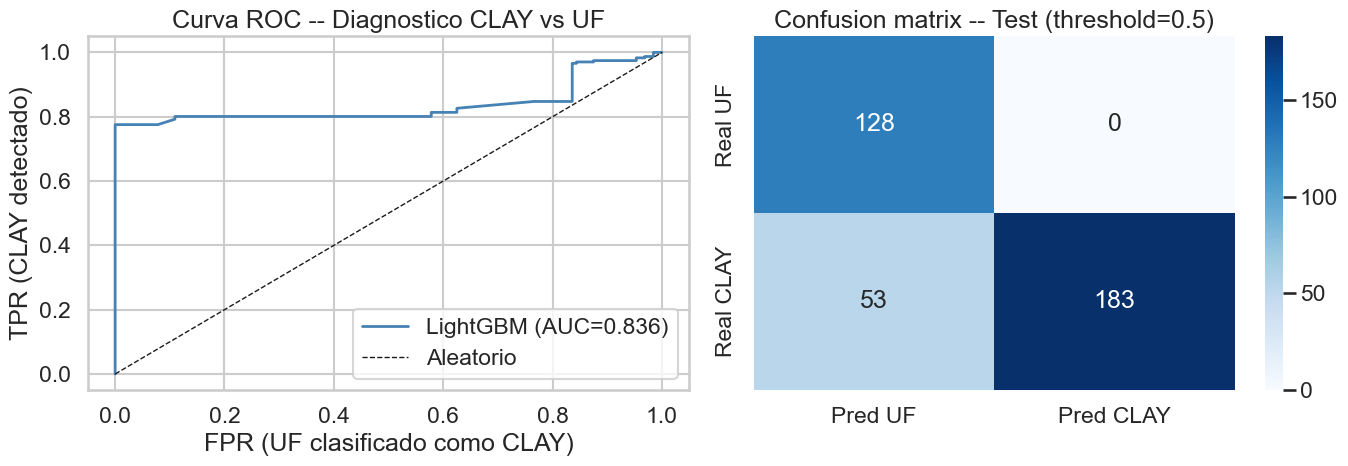

In [8]:
y_prob_diag = model_diag.predict_proba(X_test_d)[:, 1]   # P(CLAY)
y_pred_diag = model_diag.predict(X_test_d)

roc_auc = roc_auc_score(y_test, y_prob_diag)
print(f'ROC-AUC (CLAY vs UF): {roc_auc:.4f}')
print()
print(classification_report(y_test, y_pred_diag, labels=[0,1],
                             target_names=['UF','CLAY']))

fpr, tpr, _ = roc_curve(y_test, y_prob_diag)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(fpr, tpr, color='steelblue', lw=2, label=f'LightGBM (AUC={roc_auc:.3f})')
axes[0].plot([0,1],[0,1],'k--', lw=1, label='Aleatorio')
axes[0].set_xlabel('FPR (UF clasificado como CLAY)')
axes[0].set_ylabel('TPR (CLAY detectado)')
axes[0].set_title('Curva ROC -- Diagnostico CLAY vs UF')
axes[0].legend()

cm = confusion_matrix(y_test, y_pred_diag, labels=[0,1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Pred UF', 'Pred CLAY'],
            yticklabels=['Real UF', 'Real CLAY'])
axes[1].set_title('Confusion matrix -- Test (threshold=0.5)')

plt.tight_layout()
plt.show()


## 6. Análisis de umbral operacional

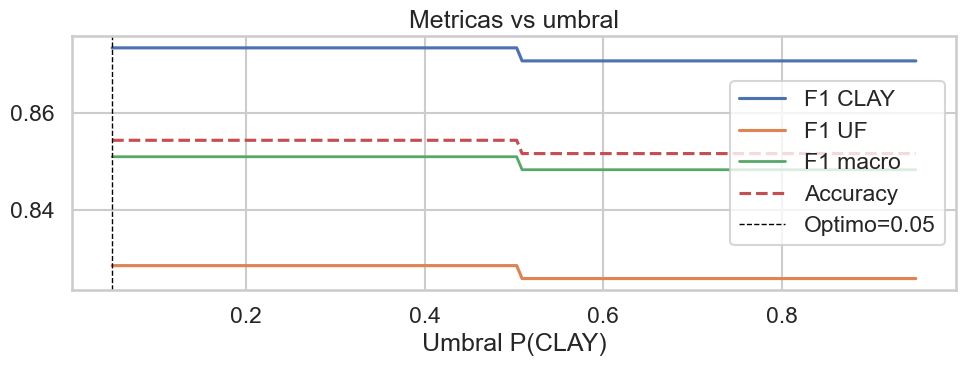

Umbral optimo: 0.050
              precision    recall  f1-score   support

          UF       0.71      1.00      0.83       128
        CLAY       1.00      0.78      0.87       236

    accuracy                           0.85       364
   macro avg       0.85      0.89      0.85       364
weighted avg       0.90      0.85      0.86       364



In [9]:
thr_range = np.linspace(0.05, 0.95, 150)
rows = []
for t in thr_range:
    yp = (y_prob_diag >= t).astype(int)
    rows.append({
        'threshold': t,
        'acc':       (yp == y_test).mean(),
        'f1_clay':   f1_score(y_test, yp, pos_label=1, zero_division=0),
        'f1_uf':     f1_score(y_test, yp, pos_label=0, zero_division=0),
    })
thr_df = pd.DataFrame(rows)
thr_df['f1_macro'] = (thr_df['f1_clay'] + thr_df['f1_uf']) / 2

best_idx = thr_df['f1_macro'].idxmax()
best_thr = thr_df.loc[best_idx, 'threshold']

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(thr_df['threshold'], thr_df['f1_clay'],  label='F1 CLAY')
ax.plot(thr_df['threshold'], thr_df['f1_uf'],    label='F1 UF')
ax.plot(thr_df['threshold'], thr_df['f1_macro'], label='F1 macro', lw=2)
ax.plot(thr_df['threshold'], thr_df['acc'],      label='Accuracy', ls='--')
ax.axvline(best_thr, color='black', ls='--', lw=1, label=f'Optimo={best_thr:.2f}')
ax.set_xlabel('Umbral P(CLAY)')
ax.set_title('Metricas vs umbral')
ax.legend()
plt.tight_layout()
plt.show()

y_opt = (y_prob_diag >= best_thr).astype(int)
print(f'Umbral optimo: {best_thr:.3f}')
print(classification_report(y_test, y_opt, labels=[0,1],
                             target_names=['UF','CLAY']))


## 7. Feature importance (gain)

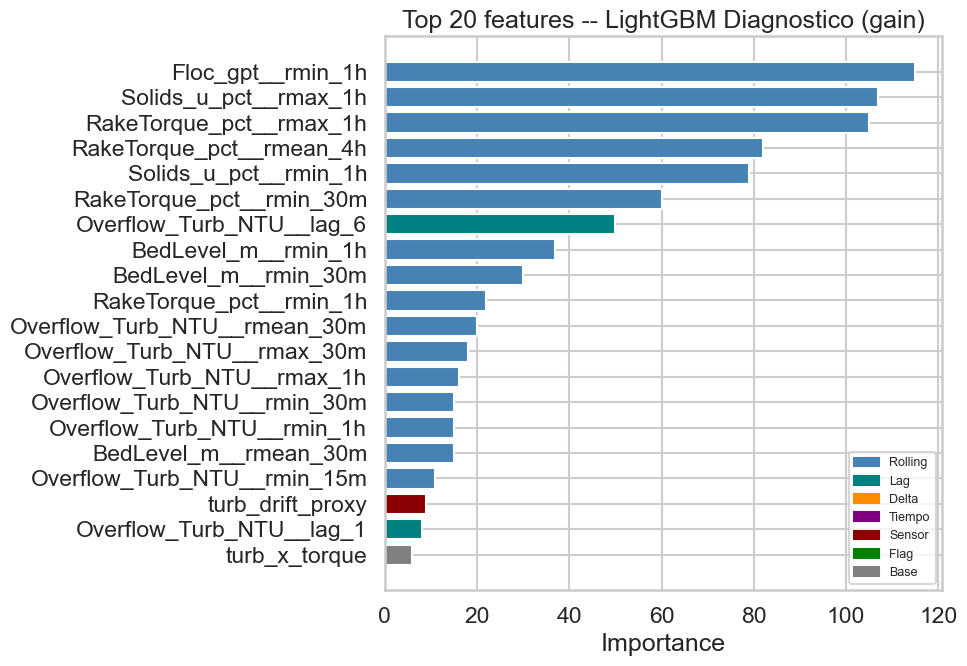

Top 15:
Floc_gpt__rmin_1h               115
Solids_u_pct__rmax_1h           107
RakeTorque_pct__rmax_1h         105
RakeTorque_pct__rmean_4h         82
Solids_u_pct__rmin_1h            79
RakeTorque_pct__rmin_30m         60
Overflow_Turb_NTU__lag_6         50
BedLevel_m__rmin_1h              37
BedLevel_m__rmin_30m             30
RakeTorque_pct__rmin_1h          22
Overflow_Turb_NTU__rmean_30m     20
Overflow_Turb_NTU__rmax_30m      18
Overflow_Turb_NTU__rmax_1h       16
Overflow_Turb_NTU__rmin_30m      15
Overflow_Turb_NTU__rmin_1h       15


In [10]:
imp = pd.Series(
    model_diag.feature_importances_,
    index=FEAT_DIAG
).sort_values(ascending=False)

top20 = imp.head(20)

def feature_group(name):
    if '__rmean_' in name or '__rstd_' in name or '__rmax_' in name or '__rmin_' in name:
        return 'Rolling'
    if '__lag_' in name:
        return 'Lag'
    if '__d1' in name or '__d6' in name or '__accel' in name:
        return 'Delta'
    if name in ('hour_sin','hour_cos','dow_sin','dow_cos','hour_of_day'):
        return 'Tiempo'
    if 'turb_cv' in name or 'turb_dev' in name or 'turb_drift' in name:
        return 'Sensor'
    if name in ('is_CLAY','is_UF','is_MANUAL','turb_above_50','turb_above_100','bed_high','torque_high'):
        return 'Flag'
    return 'Base'

palette = {'Rolling':'steelblue','Lag':'teal','Delta':'darkorange',
           'Tiempo':'purple','Sensor':'darkred','Flag':'green','Base':'gray'}
colors  = [palette[feature_group(f)] for f in top20.index]

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(top20.index[::-1], top20.values[::-1], color=colors[::-1])
ax.set_title('Top 20 features -- LightGBM Diagnostico (gain)')
ax.set_xlabel('Importance')
handles = [mpatches.Patch(color=c, label=g) for g, c in palette.items()]
ax.legend(handles=handles, loc='lower right', fontsize=9)
plt.tight_layout()
plt.show()

print('Top 15:')
print(imp.head(15).to_string())


## 8. SHAP — interpretabilidad de las firmas diagnósticas

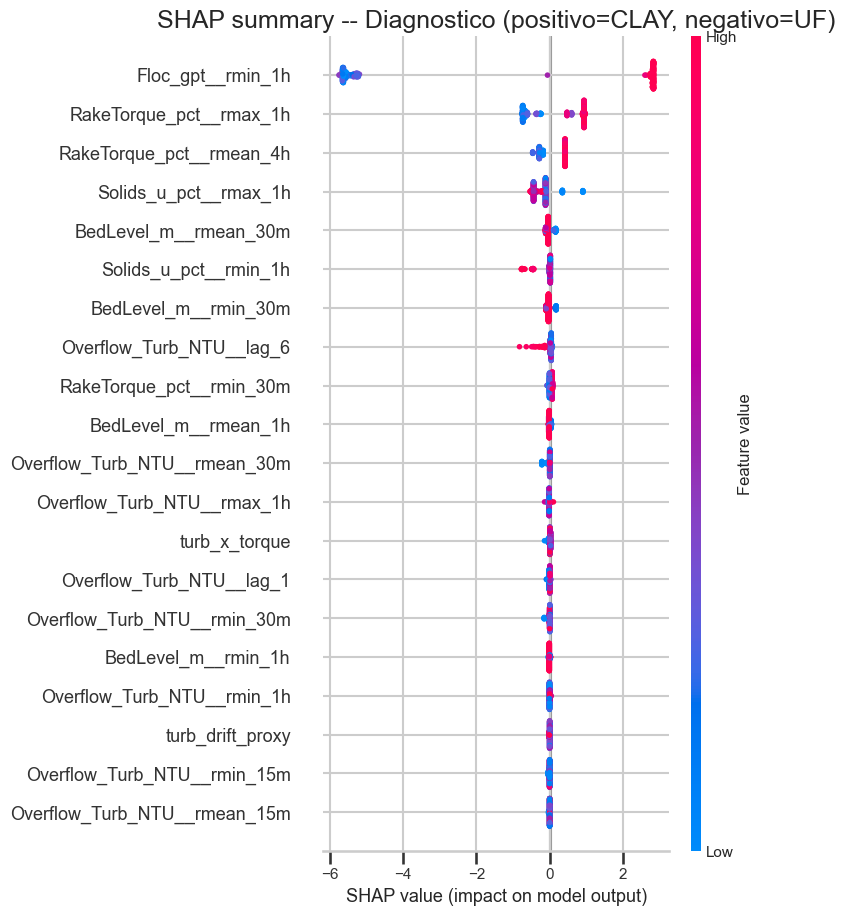

In [11]:
explainer   = shap.TreeExplainer(model_diag)
shap_values = explainer.shap_values(X_test_d)

sv = shap_values[1] if isinstance(shap_values, list) else shap_values

plt.figure(figsize=(10, 7))
shap.summary_plot(sv, X_test_d, max_display=20, show=False)
plt.title('SHAP summary -- Diagnostico (positivo=CLAY, negativo=UF)')
plt.tight_layout()
plt.show()


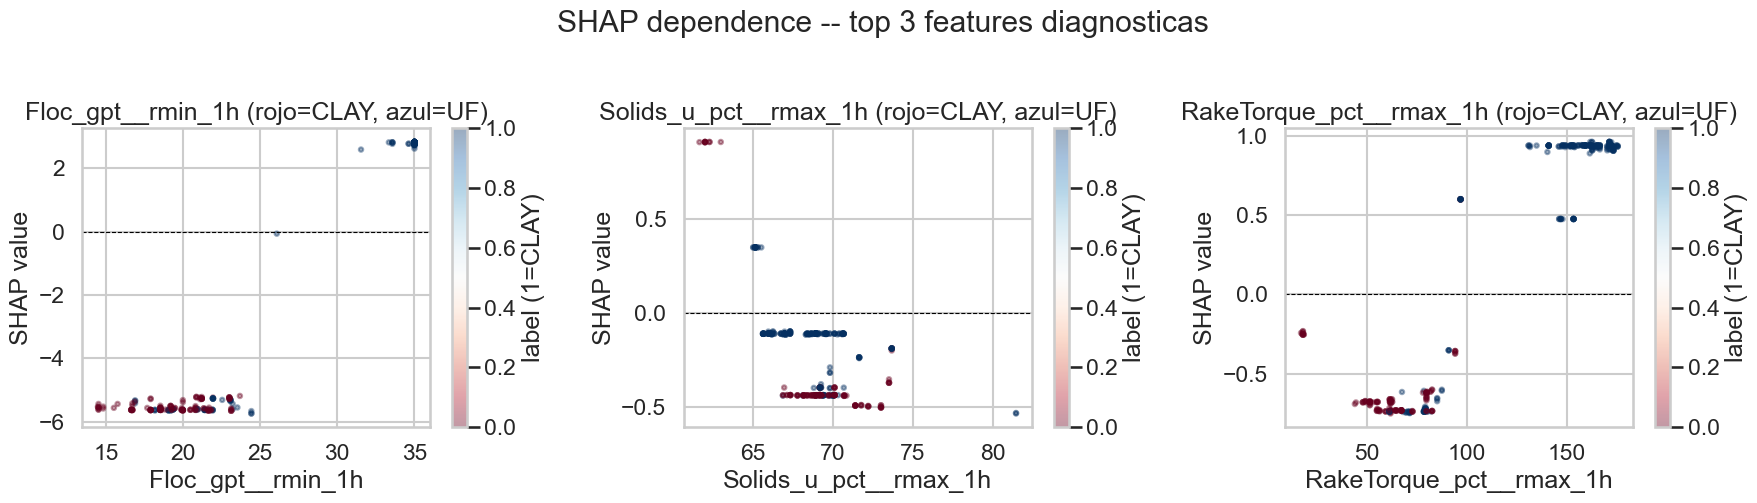

In [12]:
top3 = imp.head(3).index.tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, feat_name in zip(axes, top3):
    feat_idx = FEAT_DIAG.index(feat_name)
    sc = ax.scatter(
        X_test_d[feat_name].values,
        sv[:, feat_idx],
        c=y_test.values,
        cmap='RdBu',
        alpha=0.4,
        s=10
    )
    ax.axhline(0, color='black', lw=0.8, ls='--')
    ax.set_xlabel(feat_name)
    ax.set_ylabel('SHAP value')
    ax.set_title(feat_name + ' (rojo=CLAY, azul=UF)')
    plt.colorbar(sc, ax=ax, label='label (1=CLAY)')

plt.suptitle('SHAP dependence -- top 3 features diagnosticas', y=1.02)
plt.tight_layout()
plt.show()


## 9. Resumen ejecutivo y limitaciones en producción

In [13]:
bl_roc = roc_auc_score(y_test, test_diag['BedLevel_m'].values)
bl_acc = (y_bl_best == y_test).mean()
bl_f1  = f1_score(y_test, y_bl_best, average='macro', zero_division=0)

md_acc = (y_opt == y_test).mean()
md_f1  = f1_score(y_test, y_opt, average='macro', zero_division=0)

summary = pd.DataFrame({
    'Modelo': ['Baseline (BedLevel > umbral)', 'LightGBM TOP30_PROD'],
    'ROC-AUC': [bl_roc, roc_auc],
    'Accuracy': [bl_acc, md_acc],
    'F1-macro': [bl_f1, md_f1],
})

print('=== RESUMEN EJECUTIVO -- DIAGNOSTICO CLAY vs UF ===')
print(summary.set_index('Modelo').to_string())

print(f'\n--- Configuracion ---')
print(f'Features: {len(FEAT_DIAG)} (FEATURES_TOP30_PROD)')
print(f'Train: {len(train_diag)} eventos | Test: {len(test_diag)} eventos')
print(f'Umbral optimo P(CLAY): {best_thr:.3f}')

tn, fp, fn, tp = confusion_matrix(y_test, y_opt, labels=[0,1]).ravel()
print(f'\n--- Significado operacional ---')
print(f'CLAY detectados correctamente : {tp}/{(y_test==1).sum()} ({tp/(y_test==1).sum():.1%})')
print(f'UF detectados correctamente   : {tn}/{(y_test==0).sum()} ({tn/(y_test==0).sum():.1%})')
print(f'CLAY mal clasificados como UF : {fn}')
print(f'UF mal clasificados como CLAY : {fp}')

print('''
=== HALLAZGO CLAVE ===
El baseline (BedLevel > umbral) supera al modelo ML en este dataset.

Razon: BedLevel_m es un discriminador casi perfecto CLAY vs UF:
  CLAY -> nivel de lecho alto y sostenido (arcilla forma capa densa y rigida)
  UF   -> nivel moderado (falla en purga, no en formacion de cama)

El ML agrega valor cuando:
  1. BedLevel tiene fallas de sensor (stuck/spike)
  2. Se quiere detectar el tipo de evento ANTES de que BedLevel diverja
  3. Se combinan senales de torque + caudal + turbidez para mayor robustez

Recomendacion para produccion:
  -> Usar BedLevel como regla primaria de diagnostico
  -> Usar LightGBM como segunda opinion y deteccion temprana
''')


=== RESUMEN EJECUTIVO -- DIAGNOSTICO CLAY vs UF ===
                               ROC-AUC  Accuracy  F1-macro
Modelo                                                    
Baseline (BedLevel > umbral)  0.922438  0.931319  0.923100
LightGBM TOP30_PROD           0.836302  0.854396  0.850994

--- Configuracion ---
Features: 30 (FEATURES_TOP30_PROD)
Train: 845 eventos | Test: 364 eventos
Umbral optimo P(CLAY): 0.050

--- Significado operacional ---
CLAY detectados correctamente : 183/236 (77.5%)
UF detectados correctamente   : 128/128 (100.0%)
CLAY mal clasificados como UF : 53
UF mal clasificados como CLAY : 0

=== HALLAZGO CLAVE ===
El baseline (BedLevel > umbral) supera al modelo ML en este dataset.

Razon: BedLevel_m es un discriminador casi perfecto CLAY vs UF:
  CLAY -> nivel de lecho alto y sostenido (arcilla forma capa densa y rigida)
  UF   -> nivel moderado (falla en purga, no en formacion de cama)

El ML agrega valor cuando:
  1. BedLevel tiene fallas de sensor (stuck/spike)
  2. 